# Yelp Data 

Import the python scientific suite

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model

from collections import defaultdict

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division

%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'business_name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

In [3]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'review_without_text_year.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
s = pd.read_csv('static_stats.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2,5,30,50,61,63,80,87,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
b = CountInstance(b, 'z_hood') #add number of businesses per neighborhood column
r = CountInstance(r, 'business_id')  #add number of reviews per business column

In [5]:
min_business_per_neighborhood = 2
min_reviews_per_business = 2
min_stores_per_chain = 35
min_reviews_per_user = 5

bf = b[(b['n_z_hood'] >= min_business_per_neighborhood)] #omit neighborhoods with less than 
tc = TopChains(bf, min_stores_per_chain) #compute the top chains
bf = bf[bf['name'].isin(tc)] #filter to just the top chains
rf = pd.merge(r, bf, on = 'business_id', how = 'inner') #find just these reviews
rf = rf[(rf['n_business_id'] >= min_reviews_per_business)]

uf = u[(u['review_count'] >= min_reviews_per_user)] #users filtered by min reviews per user
rfu = pd.merge(rf, uf, on = 'user_id', how = 'inner') #reviews written by "good" users

rs = pd.merge(rfu, s, on = 'z_hood', how = 'inner') #dataframe of reviews with zhvi data
bs = pd.merge(bf, s, on = 'z_hood', how = 'inner') #dataframe of business with zhvi data

In [18]:
not_attr_columns = [c for c in rs.columns if 'attributes' not in c] #filter out attributes columns
not_hours_columns = [c for c in not_attr_columns if 'hours' not in c]

In [20]:
rfs = rs[not_hours_columns]

In [21]:
rfs.head()

,Unnamed: 0_x,review_id,user_id,business_id,year,date,stars_x,n_business_id,Unnamed: 0_y,categories,...,loop_i,state_y,county,city_y,neighborhood,lon,lat,lon_width,lat_width,bbox_area
0,1598,88iRxRFrJ3ddFwBEyb2dfQ,fVnY5R9Wx8nhER6iWhcrsA,rM-yscH8mBLYvpWnmvuPMw,2012.153005,2012-02-26,1,7,11,"['Hair Salons', 'Beauty & Spas']",...,5168.0,PA,Allegheny,Pittsburgh,Shadyside,-79.931018,40.45389,0.037291,0.013588,1.69261
1,1600,c6vzQP05Tu_iqVFTM_TiYw,I0J95fjfPm890l22dyLnKA,rM-yscH8mBLYvpWnmvuPMw,2014.169863,2014-03-04,3,7,11,"['Hair Salons', 'Beauty & Spas']",...,5168.0,PA,Allegheny,Pittsburgh,Shadyside,-79.931018,40.45389,0.037291,0.013588,1.69261
2,1601,hlgeTvjVY2Vl0xEMpyRhBA,JWtFuKaFXn_l5h-qKZWZuQ,rM-yscH8mBLYvpWnmvuPMw,2014.421918,2014-06-04,1,7,11,"['Hair Salons', 'Beauty & Spas']",...,5168.0,PA,Allegheny,Pittsburgh,Shadyside,-79.931018,40.45389,0.037291,0.013588,1.69261
3,1602,gatYE6z5zemHqIbRWjS4DA,RSExP0-Boucr4QyIEzZi0A,rM-yscH8mBLYvpWnmvuPMw,2014.523288,2014-07-11,3,7,11,"['Hair Salons', 'Beauty & Spas']",...,5168.0,PA,Allegheny,Pittsburgh,Shadyside,-79.931018,40.45389,0.037291,0.013588,1.69261
4,1372718,VsvjQCw1tPhC-gQflaOEkQ,RSExP0-Boucr4QyIEzZi0A,15I-8lBqswpncTCGWJNDLQ,2014.153425,2014-02-26,4,10,22788,"['Food', 'Coffee & Tea']",...,5168.0,PA,Allegheny,Pittsburgh,Shadyside,-79.931018,40.45389,0.037291,0.013588,1.69261


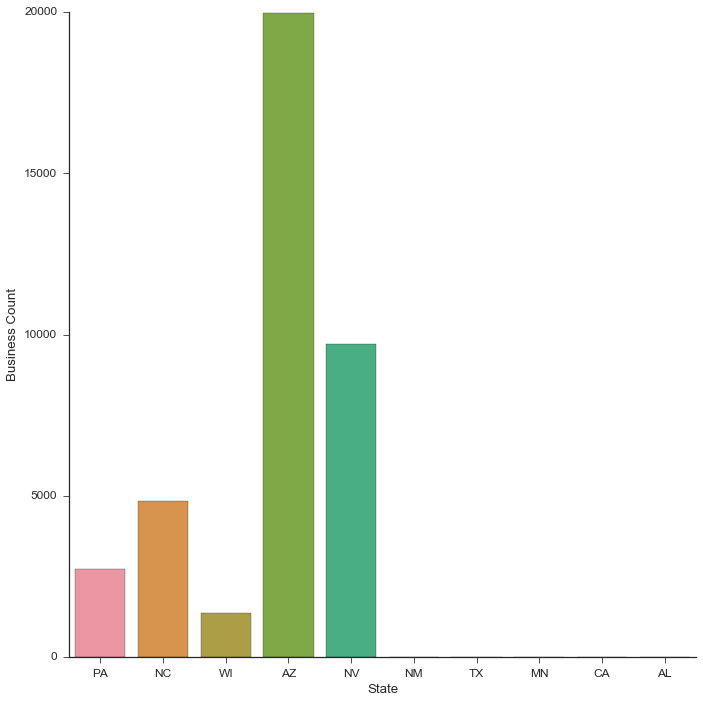

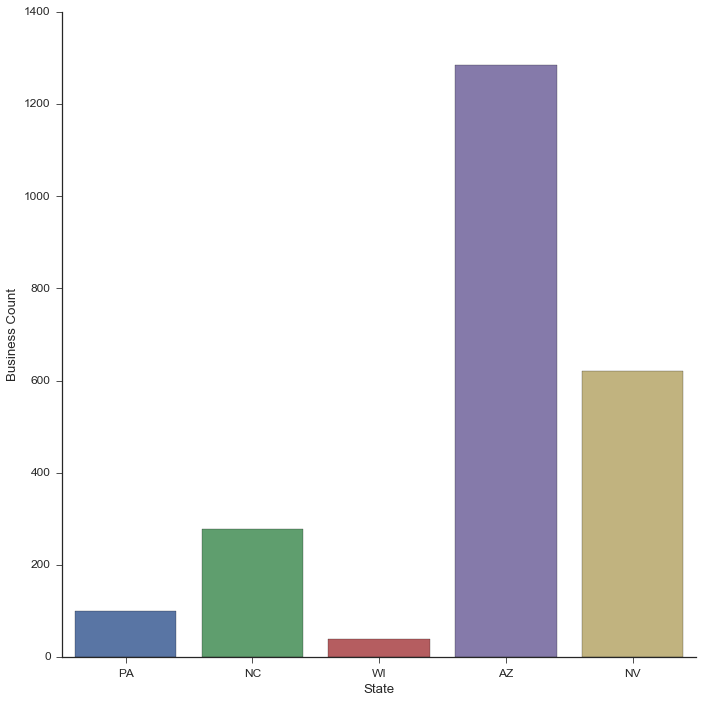

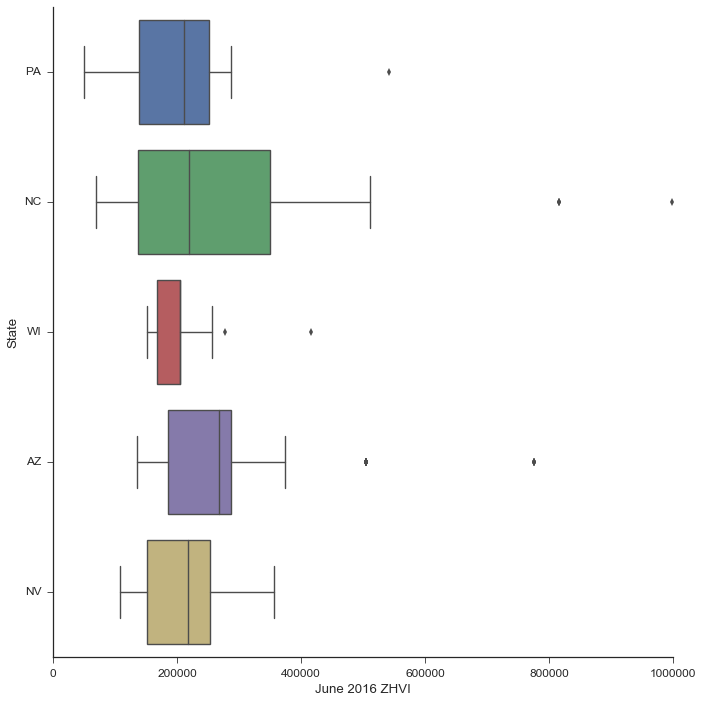

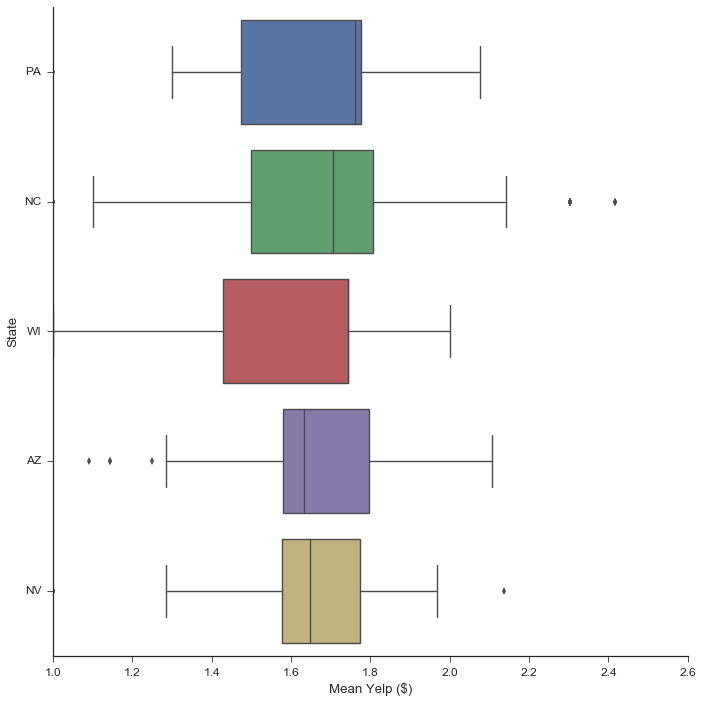

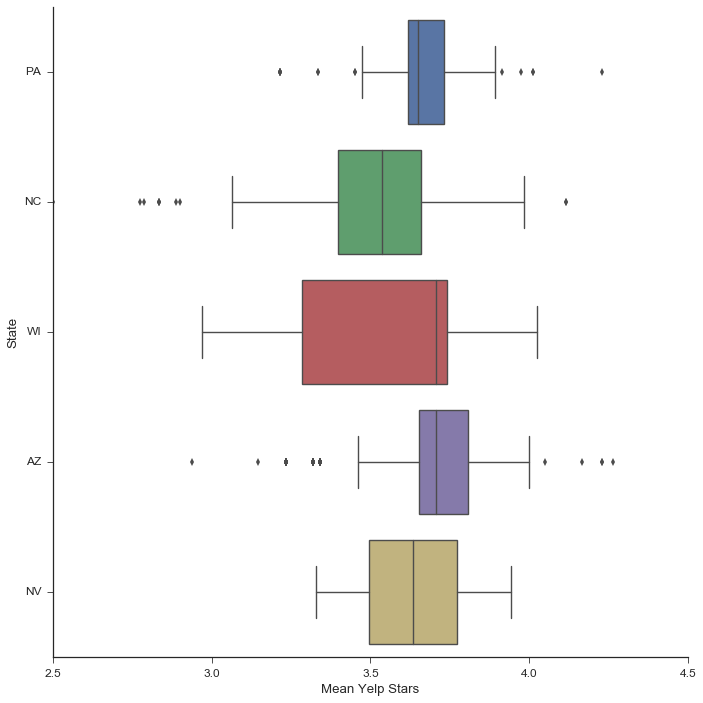

In [15]:
#total dataset
plt.figure()
sns.countplot(data = b, x = 'state')
plt.xlabel('State')
plt.ylabel('Business Count')
sns.despine()

#matched and filtered
plt.figure()
sns.countplot(data = bs, x = 'state_y')
plt.xlabel('State')
plt.ylabel('Business Count')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'state_y')
plt.ylabel('State')
plt.xlabel('June 2016 ZHVI')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'mean_price', y = 'state_y')
plt.ylabel('State')
plt.xlabel('Mean Yelp ($)')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'mean_stars', y = 'state_y')
plt.ylabel('State')
plt.xlabel('Mean Yelp Stars')
sns.despine()

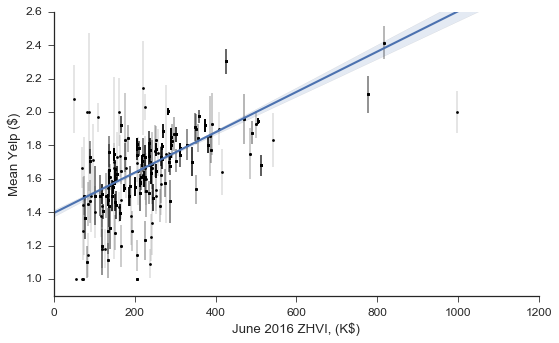

In [20]:
pylab.rcParams['figure.figsize'] = (8.0, 5.0) #set figure parameters
plt.figure()
plt.errorbar(bs['latest_zhvi']/1000.0, bs['mean_price'], bs['mean_price_err'], fmt = 'k.', lw = 0.2)
sns.regplot(bs['latest_zhvi']/1000.0, bs['mean_price'], bs['mean_price_err'], scatter_kws = {'s': 0})
plt.xlabel('June 2016 ZHVI, (K$)')
plt.ylabel('Mean Yelp ($)')
plt.ylim(0.9,2.6)
#plt.colorbar(label = 'Number of Businesses in Neighborhood')
sns.despine()
plt.savefig('mean_yelp_price_vs_zhvi.png', fmt = 'png', dpi = 300)

In [18]:
su = pd.read_csv('superuser_ids.csv')

In [19]:
su

,Unnamed: 0,user_id
0,25,-087cNxyD11jpuF8wfxzVQ
1,26,-1LYnK3QRMWBAdD1WuGdJQ
2,27,-1p8HJmNCFJEuJAOBKPw4g
3,28,-2sGVnUcv9VXKOl3RgEG3w
4,29,-6CEHR3KyP2fO3J50OV6fA
5,30,-H7ZKpT8VZp1i4f7XaddDw
6,31,-JlJf9qe79b07GB24-h6jA
7,32,-KM6PeCk4Gj0emYWPF7hiA
8,33,-UPb7jd2li5mcp02Eq4uMg
9,34,-curwG7tAd6_E0fWVtX6yA


In [13]:
def MakeFracs(rsc):
    
    fracs = defaultdict(list) #initialize empty dictionary to store fraction informaion

    for zhvi in pd.Series(np.unique(rsc['latest_zhvi'])).dropna(): #for every non-na zhvi
        
        ss = rsc[(rsc['latest_zhvi'] == zhvi)] #subset by zhvi
        
        for i in range(1,6): #for stars in [1,2,3,4,5]
            fracs[int(zhvi)].append(float(len(ss[(ss['stars_x'] == i)])/len(ss))) # compute fraction of reviews with star i over total
    
        fracs[int(zhvi)].append(len(ss)) #append the total number of reviews in zhvi
    
    fracs_df = pd.DataFrame(fracs).T #create the dataframe, reset the index, and rename the columns
    fracs_df.reset_index(level=0, inplace=True)
    fracs_df.rename(columns = {'index': 'zhvi',\
                              0:1, 1:2, 2:3, 3:4, 4:5, 5:'n'}, inplace = True)

    #compute polarization metric
    fracs_df['polarization'] = (fracs_df[1] + fracs_df[5])/(fracs_df[1] + fracs_df[2] + fracs_df[3] + fracs_df[4])
    
    return fracs_df

def FracWLS(fracs_df, star):

    X = fracs_df['zhvi']
    X = sm.add_constant(X)
    y = fracs_df[star]
    w = fracs_df['n']

    lin = sm.WLS(y, X, weights = w).fit()

    return lin, np.average(y, weights = w)

In [381]:
myfile = open('chain_regressions.csv','w')
np.savetxt(myfile, ['chain','star','zhvi_p'\
                    ,'cst_p','zhvi_c','cst_c','w_avg','n_rev', 'n_rev_star'],\
           newline = ' ',fmt = '%s', delimiter = ',')
myfile.write('\n')
myfile.close()

for chain in tc: #for every chain in the list of top chains
    
    myfile = open('chain_regressions.csv','a')
    
    rsc = rs[(rs['name_x'] == chain)] #create a dataframe of reviews of that chain

    f_df = MakeFracs(rsc) #compute the review fractions for that dataframe
    
    for star in [1,2,3,4,5]: #for each possible star value
        lin, w_avg = FracWLS(f_df, star) #compute a linear fit of fraction as a function of zhvi

        w_line = np.hstack((chain.replace(" ",""),star,lin.pvalues.zhvi,\
                        lin.pvalues.const,\
                        lin.params.zhvi,\
                        lin.params.const,\
                        w_avg, len(rsc), len(rsc[(rsc['stars_x'] == star)])))
        
        #write the line to a file
        
        np.savetxt(myfile, w_line, newline = ' ',fmt = '%s', delimiter = ',')
        myfile.write('\n')
    myfile.close()

In [356]:
reg_s = pd.read_csv('chain_regressions.csv', delim_whitespace = True)

In [378]:
reg_s['c_hyp'], reg_s['c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(reg_s['zhvi_p'],\
                                                  method = 'fdr_bh', alpha = 0.3)

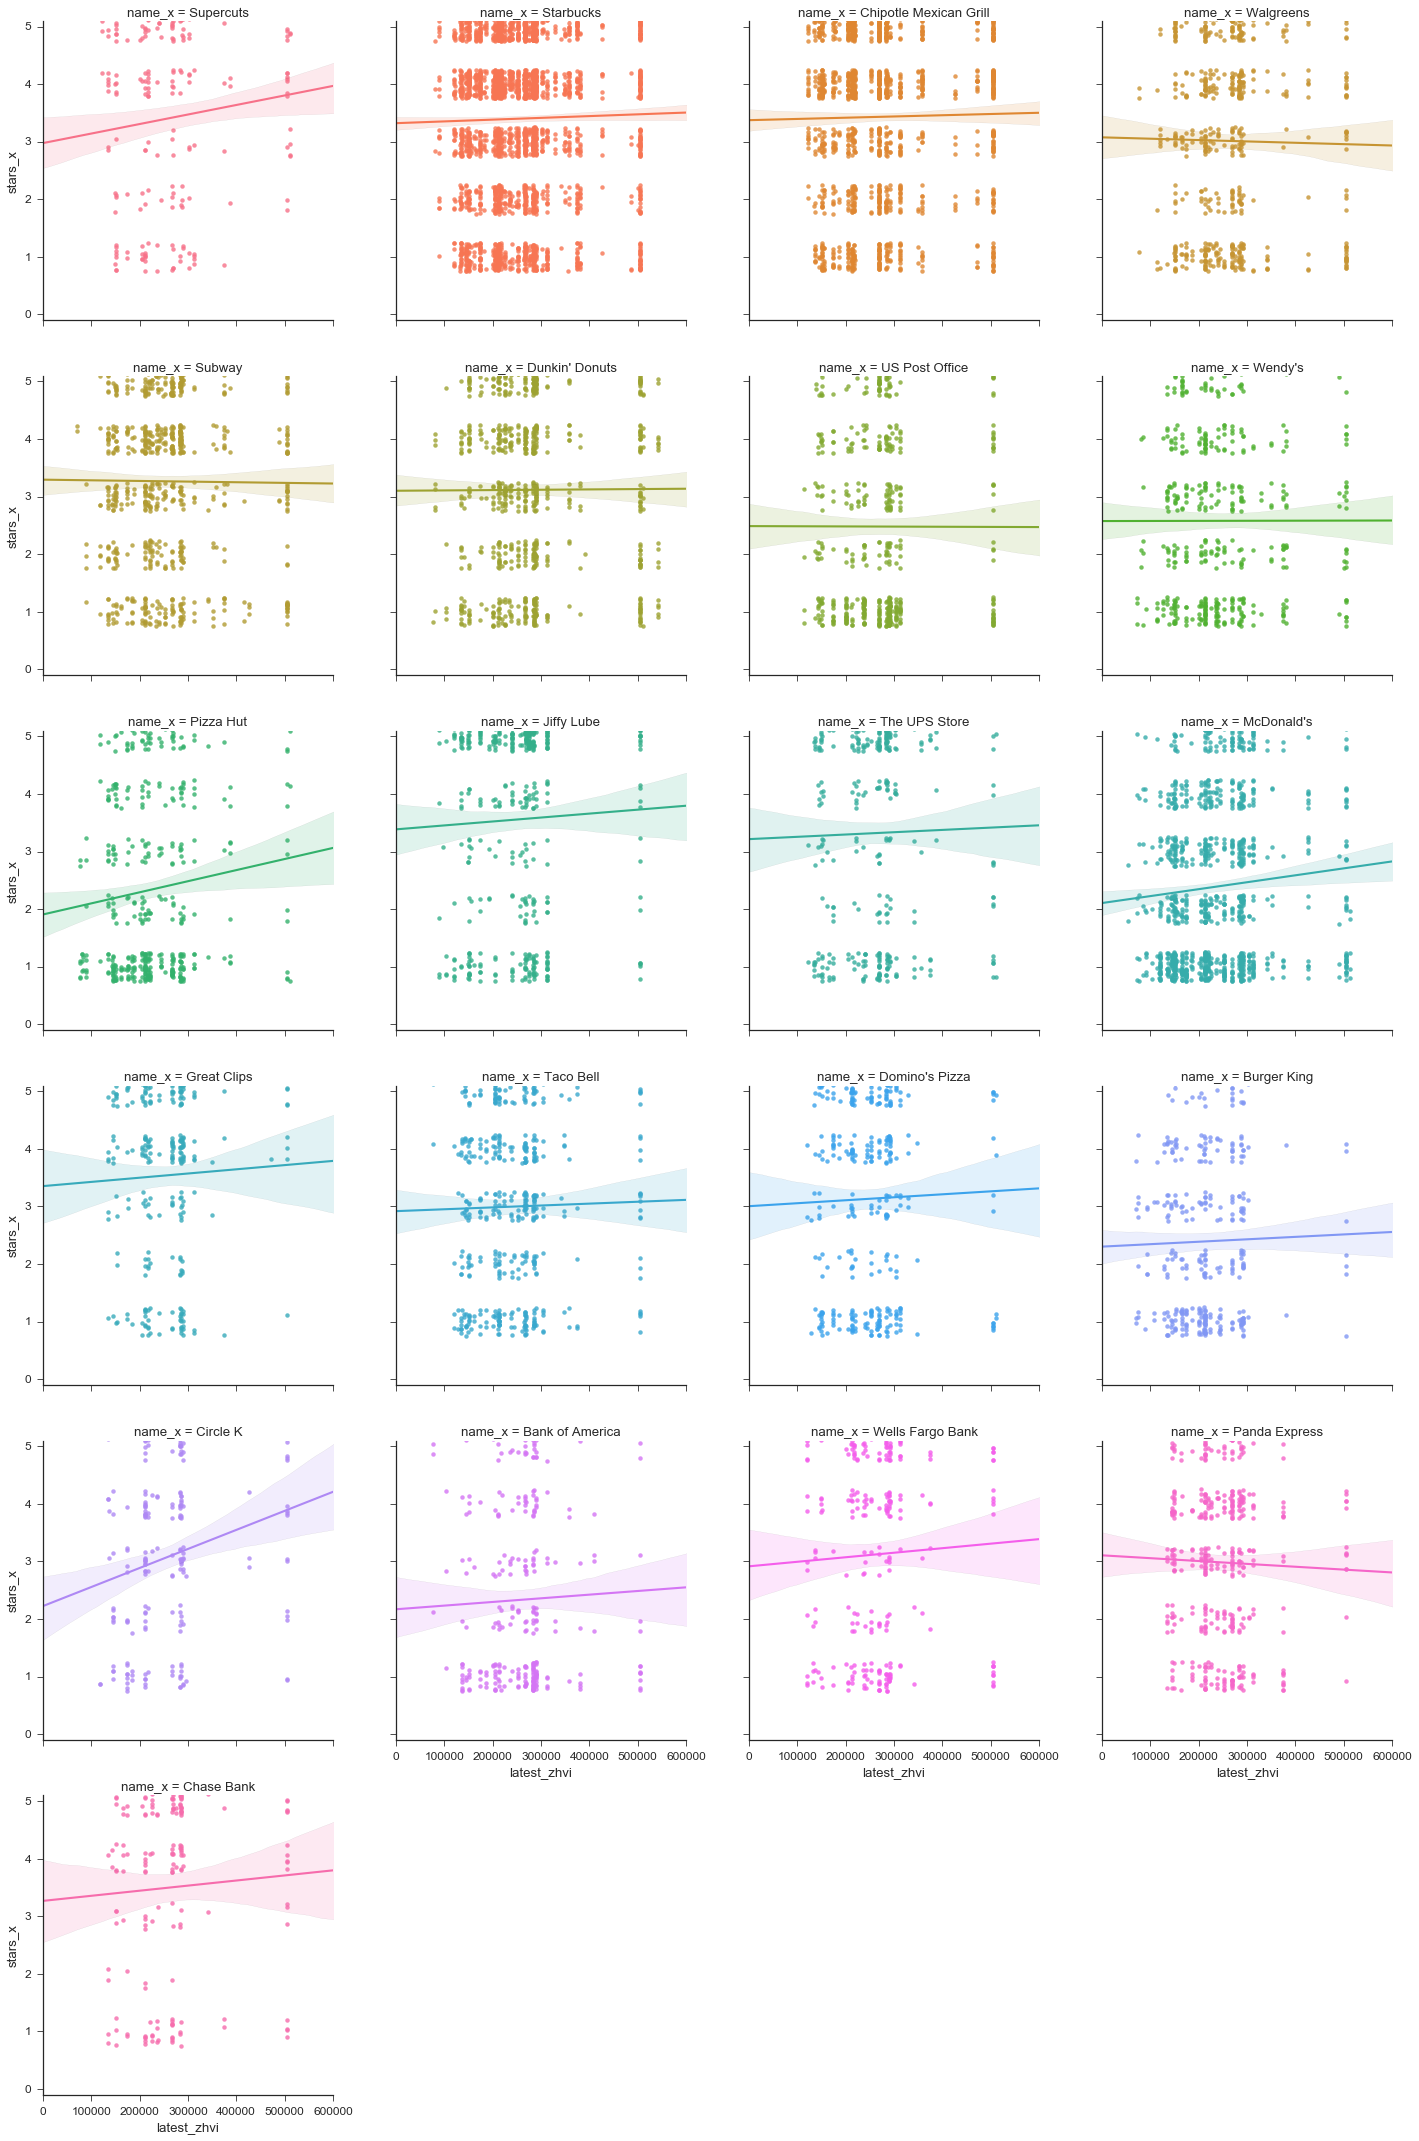

In [121]:
sns.lmplot(x = 'latest_zhvi', y = 'stars_x', col = 'name_x', hue = 'name_x', y_jitter = 0.25,  col_wrap = 4, data = rs)
plt.ylim(-0.1,5.1)
plt.xlim(0,600000)
sns.despine()
#plt.savefig('example_chain_regressions.png', dpi = 300, fmt = 'png')

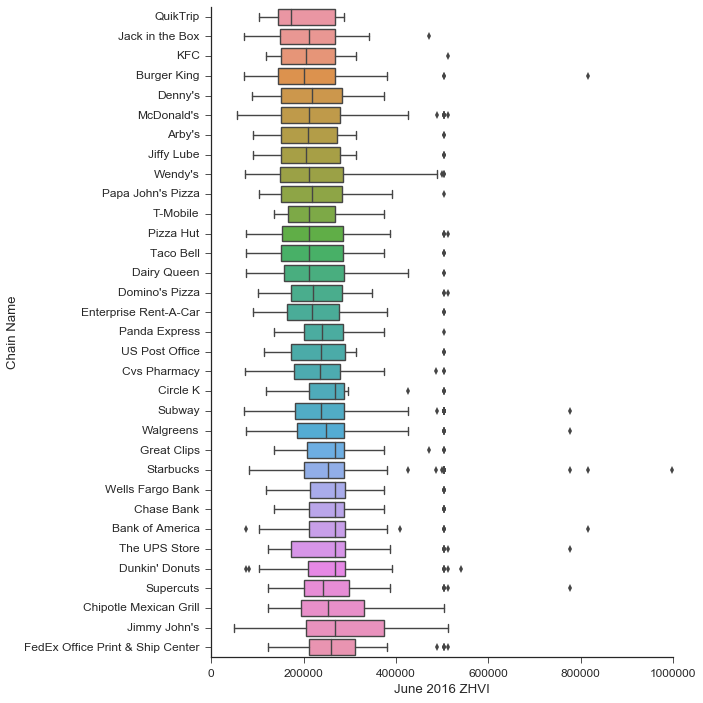

In [18]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0) #set figure parameters
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'name', order = OrderName(bs, 'name', 'latest_zhvi'))
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Chain Name')
sns.despine()
plt.savefig('rich_and_poor_chains.png', dpi = 300, fmt = 'png')

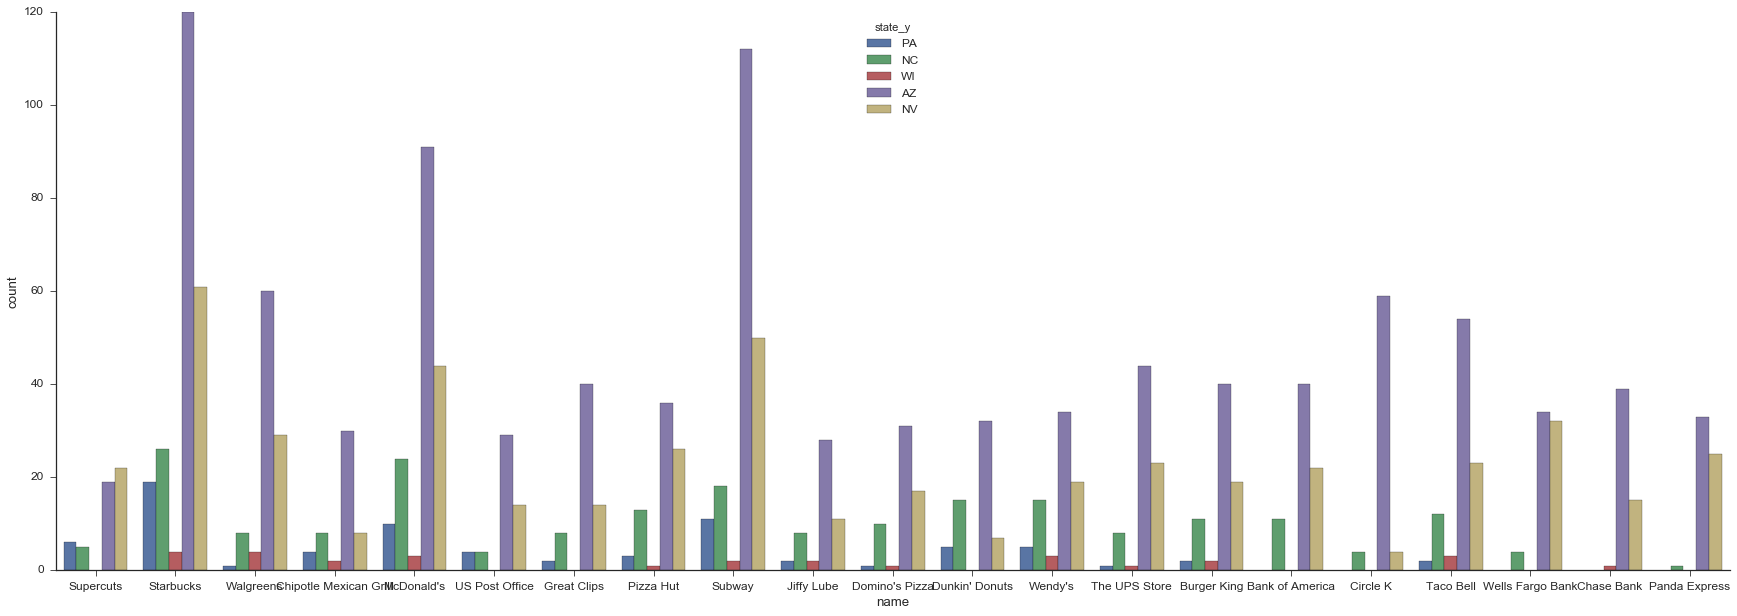

In [29]:
pylab.rcParams['figure.figsize'] = (30.0, 10.0) #set figure parameters
sns.countplot(data = bs, x = 'name', hue = 'state_y')
sns.despine()